# Particle Filter

In this notebook you'll combine code from the previous notebooks and implement a particle filter. In pseudocode the particle filter algorithm is:

```
particles = sample N times from prior distribution
for t in range(timesteps):
    # from Numerical Estimation
    particles = propagate distribution with the vehicle model
    # from Sensor Fusion
    weights = estimate probability/weights of particles via sensor fusion
    particles = sample new particles from the weighted distribution
```

The final distribution resemble the actual state of the vehicle.

In [11]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from bresenham import bresenham
from utils import create_grid, valid_location, inbounds

In [12]:
plt.rcParams['figure.figsize'] = 13, 13

Load data.

In [13]:
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
grid, _, _ = create_grid(data)

Code based on previous notebooks.

**NOTE: You'll notice if there's prior knowledge of the state, the $\theta$ of samples is centered around the passed state's $\theta$ value, otherwise it's sampled from [0, 360] degrees.**

In [14]:
# Numerical Esitmation Code

def sample_from_prior(grid_map, N, state=None):
    samples = []
    
    while len(samples) < N:
        x = np.random.uniform(0, grid.shape[1])
        y = np.random.uniform(0, grid.shape[0])
       
        # Feel free to alter this distribution
        if state is None:
            theta = np.random.uniform(-np.pi, np.pi)
        else:
            theta = np.random.normal(state[2], np.radians(0.5))
            
        s = [x, y, theta]
        if valid_location(grid_map, int(x), int(y)):
            samples.append(s)
            
    return np.array(samples)

def simulate(state, angle=np.radians(0), v=5, dt=1):
    x, y, theta = state
    
    w = [np.random.normal(), np.random.normal(), np.random.normal(0, 0.015)]
    
    x_new = x + v*np.cos(theta)*dt + w[0]
    y_new = y + v*np.sin(theta)*dt + w[1]
    theta_new = theta + v*np.tan(angle)*dt + w[2]
    
    return np.array([x_new, y_new, theta_new])

In [15]:
# Sensor Fusion Code

class LidarSensor:
    def __init__(self, max_range):
        self._max_range = max_range
        
    @property
    def max_range(self):
        return self._max_range
    
    def _random_measure(self):
        return np.random.randint(0, self._max_range+1)
    
    def _failure_measure(self):
        return self._max_range
    
    def _hit_measure(self, expected_dist):
        return np.random.normal(expected_dist)
    
    def measure(self, expected_dist):
        p = np.random.rand()
        if p <= 0.95:
            return self._hit_measure(expected_dist)
        elif p <= 0.98:
            return self._random_measure()
        return self._failure_measure()
    
    def lookup_prob(self, expected_dist, measured_dist):
        norm_prob = 0.95 * stats.norm.pdf(measured_dist, loc=expected_dist)
        random_prob = 0.03 * (1 / self._max_range)
        failure_prob = 0
        if measured_dist == self._max_range:
            failure_prob = 0.02
        return norm_prob + random_prob + failure_prob
    
def sense(grid, sensor, ground_truth_state, rays):
    """Generate a number of sensor measurements, `rays` from the ground truth
    state `ground_truth_state`.
    """
    measured_distances = []
    dists = shoot_rays(grid, sensor, ground_truth_state, k=rays)
    for d in dists:
        measured_distances.append(sensor.measure(d))
    return measured_distances

def sensor_fusion(grid_map, sensor, samples, measured_distances):
    """Given sampled states, `samples` and ground truth sensor
    distance measurements, `measured_distances` return the new mean
    state and standard deviation estimates.
    """
    weights = []
    for s in samples:
        weight = importance(grid_map, sensor, s, measured_distances)
        weights.append(weight)
        
    # normalize weights
    weights = np.array(weights)
    weights /= np.sum(weights)
        
    return np.array(weights)

def shoot_rays(grid_map, sensor, state, k):
    """
    Shoot `k` number of rays the given state, `state`.
    The rays will be evenly spaced.
    """
    x, y, theta = state
    expected_distances = []
    for i, bearing in enumerate(range(k)):
        bearing = bearing * (360 / k)
        angle = (theta + np.radians(bearing)) % (2 * np.pi)
        expected_dist, _ = get_distance(grid_map, sensor, x, y, angle)
        expected_distances.append(expected_dist)
    return expected_distances

def importance(grid_map, sensor, state, measured_distances):
    """Returns the "importance" of the sampled `state` based
    on a comparison between the `measured_distances` and the
    distances measured from the sampled state.
    """
    expected_distances = shoot_rays(grid_map, sensor, state, k=len(measured_distances))
    weight = 1
    
    for (ed, md) in zip(expected_distances, measured_distances):
        weight *= sensor.lookup_prob(ed, md)
        
    return weight


def get_distance(grid_map, sensor, x, y, angle):
    """Uses bresenham to find the distance to the nearest
    obstacle on the map from an observation at x, y pointed
    in a certain angle. If no obstacle is hit the max sensor range
    is returned."""        
    x2 = x + sensor.max_range * np.cos(angle)
    y2 = y + sensor.max_range * np.sin(angle)
    
    cells = bresenham(int(x), int(y), int(x2), int(y2))
            
    dist = sensor.max_range
    loc = [x2, y2]
    
    for c in cells:
        if not inbounds(grid_map, c[0], c[1]):
            return dist, loc
        
        if grid_map[c[1], c[0]] == 1:
            dist = np.linalg.norm(np.array([x, y]) - np.array([c[0], c[1]]))
            loc = [c[0], c[1]]
            break
            
    return dist, loc

### Filtering Particles

In [16]:
num_particles = 2000
max_sensor_range = 100
sensor = LidarSensor(max_sensor_range)

# initial state
init_ground_truth_state = [385, 450, np.radians(45)]
init_samples = sample_from_prior(grid, num_particles, init_ground_truth_state)

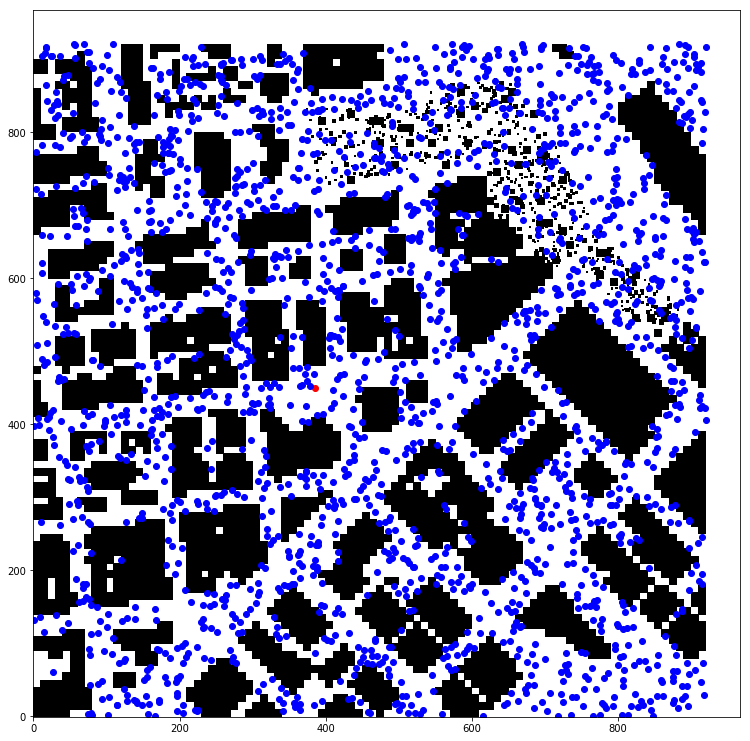

In [17]:
plt.imshow(grid, origin='lower', cmap='Greys')
plt.plot(init_ground_truth_state[0], init_ground_truth_state[1], 'ro')
plt.plot(init_samples[:, 0], init_samples[:, 1], 'bo');

Implement the particle filter!

In [18]:
def particle_filter(grid, sensor, ground_truth_state, samples, n_timesteps, rays):
    samples = np.copy(samples)
    ground_truth_state = np.copy(ground_truth_state)
    
    for t in range(n_timesteps):
        print('timestep', t+1)
        
        # simulate the vehicle model on the current samples
        for i in range(len(samples)):
            samples[i, :] = simulate(samples[i], v=5)
        ground_truth_state = simulate(ground_truth_state, v=5)

        # produce weights for sensor fusion
        measured_distances = sense(grid, sensor, ground_truth_state, rays)
        weights = sensor_fusion(grid, sensor, samples, measured_distances)

        # generate new samples from weighted distribution
        idxs = np.random.choice(range(len(samples)), size=len(samples), p=weights)
        samples = samples[idxs, :]
    
    return samples, ground_truth_state

This may take a while ...

In [19]:
n_timesteps = 5
rays = 16

%time samples, ground_truth_state = particle_filter(grid, sensor, init_ground_truth_state, init_samples, n_timesteps, rays)

timestep 1
timestep 2
timestep 3
timestep 4
timestep 5
CPU times: user 30.6 s, sys: 100 ms, total: 30.7 s
Wall time: 30.8 s


The final samples (blue dots) should be very close to the green dot.

In [ ]:
plt.imshow(grid, origin='lower', cmap='Greys')

# blue dots sampled from the final weighted distribution
plt.plot(samples[:, 0], samples[:, 1], 'bo')

# red dot is initial position
plt.plot(init_ground_truth_state[0], init_ground_truth_state[1], 'ro')

# green dot is new simulated position
plt.plot(ground_truth_state[0], ground_truth_state[1], 'go')